In [ ]:
# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost
import shap

# データを生成するためのクラスや関数を作成
class FixableDataFrame(pd.DataFrame):
    """ Helper class for manipulating generative models.
    """
    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super(FixableDataFrame, self).__init__(*args, **kwargs)
    def __setitem__(self, key, value):
        out = super(FixableDataFrame, self).__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super(FixableDataFrame, self).__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

def generator(n, fixed={}, seed=0):
    """ The generative model for our subscriber retention example.
    """
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # 訪問販売の回数
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # 交流回数
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # 消費者が住む地域の経済状況
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # 最終更新時期
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # プロダクトのニーズ（未観測）
    X["Product need"] = (X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,)))

    # 割引額
    X["Discount"] = ((1-scipy.special.expit(X["Product need"])) * 0.5 + 0.5 * np.random.uniform(0, 1, size=(n,))) / 2

    # ユーザーの利用頻度
    X["Monthly usage"] = scipy.special.expit(X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,)))

    # 広告費用
    X["Ad spend"] = X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,)) + (X["Last upgrade"] < 1) + (X["Last upgrade"] < 2)

    # ユーザーのバグ遭遇回数（未観測）
    X["Bugs faced"] = np.array([np.random.poisson(v*2) for v in X["Monthly usage"]])

    # ユーザーのバグ報告回数
    X["Bugs reported"] = (X["Bugs faced"] * scipy.special.expit(X["Product need"])).round()

    # ユーザーがサブスクを更新する確率
    X["Did renew"] = scipy.special.expit(7 * (
          0.18 * X["Product need"] \
        + 0.08 * X["Monthly usage"] \
        + 0.1 * X["Economy"] \
        + 0.05 * X["Discount"] \
        + 0.05 * np.random.normal(0, 1, size=(n,)) \
        + 0.05 * (1 - X['Bugs faced'] / 20) \
        + 0.005 * X["Sales calls"] \
        + 0.015 * X["Interactions"] \
        + 0.1 / (X["Last upgrade"]/4 + 0.25)
        + X["Ad spend"] * 0.0 - 0.45
    ))
    # ユーザーがサブスクを更新したかどうか（更新していたら1）
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X

def user_retention_dataset():
    """ The observed data for model training.
    """
    n = 10000
    X_full = generator(n)
    y = X_full["Did renew"]
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y

def fit_xgboost(X, y):
    """ Train an XGBoost model with early stopping.
    """
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        { "eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"}, dtrain, num_boost_round=200000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False
    )
    return model

# データを格納
X, y = user_retention_dataset()

# 値の確認
display(pd.DataFrame(X).head())
display(pd.DataFrame(y).head())

In [ ]:
# 予測モデルを学習
model = fit_xgboost(X, y)

# SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="complete")

# 予測モデルにおける特徴量の重要度をプロット
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

KeyboardInterrupt: 

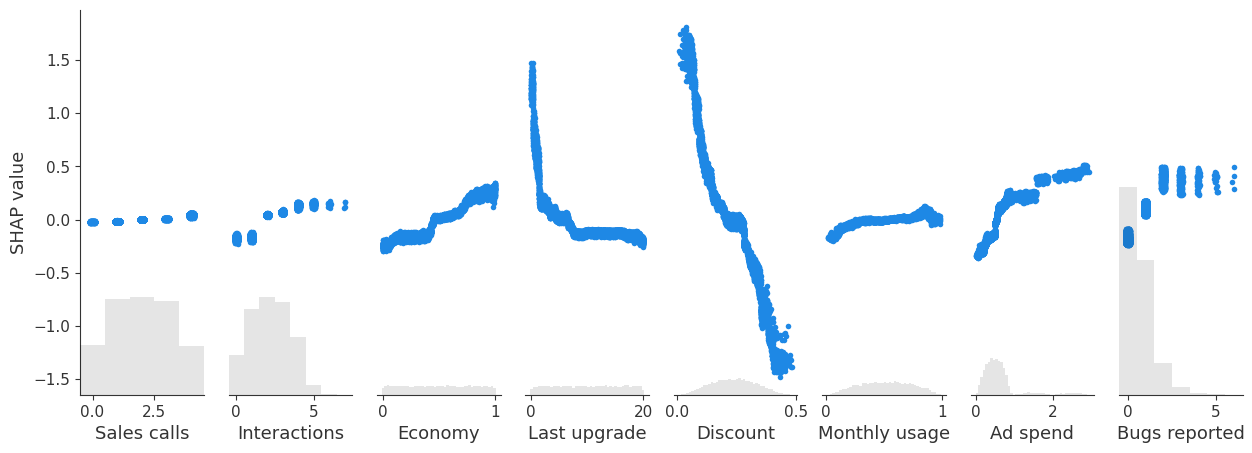

In [3]:
# 散布図を描画
shap.plots.scatter(shap_values)

/var/folders/sl/1s5bclb94fv5vmdz674d81d40000gn/T/ipykernel_86125/2871432252.py:25: DeprecationWarning: the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  "True causal effects": marginal_effects(generator, 10000, X.columns)
/var/folders/sl/1s5bclb94fv5vmdz674d81d40000gn/T/ipykernel_86125/2871432252.py:25: DeprecationWarning: the `interpolation=` argument to nanpercentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  "True causal effects": marginal_effects(generator, 10000, X.columns)
/var/folders/sl/1s5bclb94fv5vmdz674d81d40000gn/T/ipykernel_86125/2871432252.py:25: DeprecationWarning: the `interpolation=` argument to nanpercentile was renamed to `method=`, wh

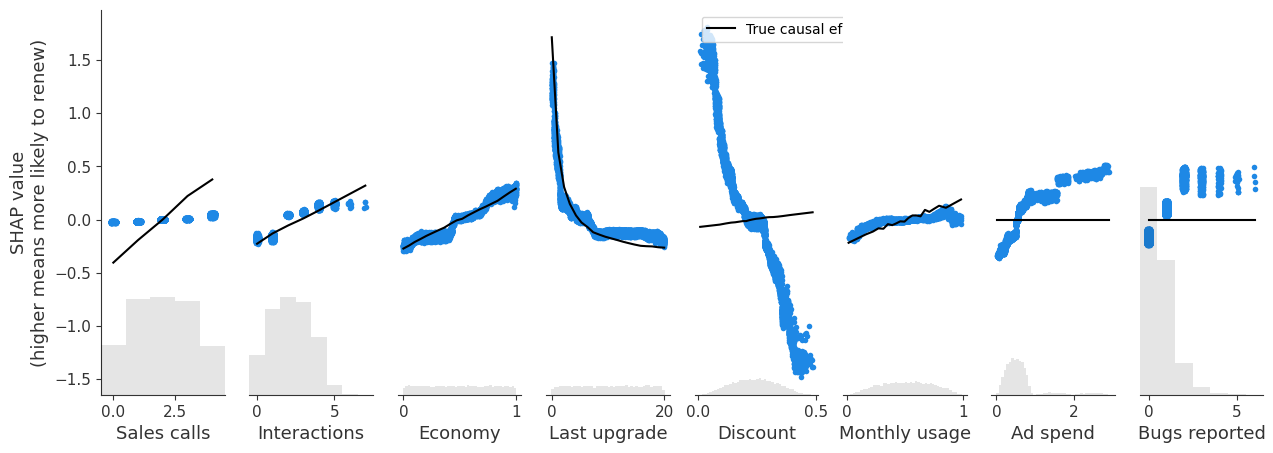

In [4]:
# SHAP値と真の因果効果をプロット
def marginal_effects(generative_model, num_samples=100, columns=None, max_points=20, logit=True, seed=0):
    """ Helper function to compute the true marginal causal effects.
    """
    X = generative_model(num_samples)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i,c in enumerate(columns):
        xs[i] = np.unique([np.nanpercentile(xs[i], v, interpolation='nearest') for v in np.linspace(0, 100, max_points)])
        for x in xs[i]:
            Xnew = generative_model(num_samples, fixed={c: x}, seed=seed)
            val = Xnew["Did renew"].mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)", overlay={
    "True causal effects": marginal_effects(generator, 10000, X.columns)
})

In [ ]:
# 必要なライブラリをインポート
from econml.dml import LinearDML
from sklearn.base import BaseEstimator, clone
import matplotlib.pyplot as plt

# DMLを実行し、因果効果の実値と推定値をプロットする関数を作成
class RegressionWrapper(BaseEstimator):
    """ Turns a classifier into a 'regressor'.

    We use the regression formulation of double ML, so we need to approximate the classifer
    as a regression model. This treats the probabilities as just quantitative value targets
    for least squares regression, but it turns out to be a reasonable approximation.
    """
    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y, **kwargs):
        self.clf_ = clone(self.clf)
        self.clf_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.clf_.predict_proba(X)[:, 1]

def double_ml(y, causal_feature, control_features):
    """ Use doubleML from econML to estimate the slope of the causal effect of a feature.
    """
    xgb_model = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
    est = LinearDML(model_y=RegressionWrapper(xgb_model))
    est.fit(y, causal_feature, W=control_features)
    return est.effect_inference()

def plot_effect(effect, xs, true_ys, causal_feature, ylim=None):
    """ Plot a double ML effect estimate from econML as a line.

    Note that the effect estimate from double ML is an average effect *slope* not a full
    function. So we arbitrarily draw the slope of the line as passing through the origin.
    """
    plt.figure(figsize=(5, 3))

    pred_xs = [xs.min(), xs.max()]
    mid = (xs.min() + xs.max())/2
    pred_ys = [effect.pred[0]*(xs.min() - mid), effect.pred[0]*(xs.max() - mid)]

    plt.plot(xs, true_ys - true_ys[0], label='True causal effect', color="black", linewidth=3)
    point_pred = effect.point_estimate * pred_xs
    pred_stderr = effect.stderr * np.abs(pred_xs)
    plt.plot(pred_xs, point_pred - point_pred[0], label='Double ML slope', color=shap.plots.colors.blue_rgb, linewidth=3)
    plt.fill_between(pred_xs, point_pred - point_pred[0] - 3.291 * pred_stderr,
                     point_pred - point_pred[0] + 3.291 * pred_stderr, alpha=.2, color=shap.plots.colors.blue_rgb)
    plt.legend()
    plt.xlabel(causal_feature, fontsize=13)
    plt.ylabel("Zero centered effect")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.show()

# Ad spendの因果効果を推定
causal_feature = "Ad spend"
control_features = [
    "Sales calls", "Interactions", "Economy", "Last upgrade", "Discount",
    "Monthly usage", "Bugs reported"
]
effect = double_ml(y, X[causal_feature], X.loc[:,control_features])

# 真の因果効果とDMLによる因果効果の推定値をプロット
xs, true_ys = marginal_effects(generator, 10000, X[["Ad spend"]], logit=False)[0]
plot_effect(effect, xs, true_ys, causal_feature, ylim=(-0.2, 0.2))

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [9]:
# Interactionsを取り除いて因果効果を推定
causal_feature = "Sales calls"
control_features = [
    "Economy", "Last upgrade", "Discount",
    "Monthly usage", "Ad spend", "Bugs reported"
]
effect = double_ml(y, X[causal_feature], X.loc[:,control_features])

# 真の因果効果とDMLによる因果効果の推定値をプロット
xs, true_ys = marginal_effects(generator, 10000, X[[causal_feature]], logit=False)[0]
plot_effect(effect, xs, true_ys, causal_feature, ylim=(-0.2, 0.2))

NameError: name 'double_ml' is not defined